# Course project. Algorithms of data analysis. 
# Classification. Choose tutors
https://www.kaggle.com/c/gb-choose-tutors

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

Let's make custom functions for classification.

Standard Scale:

$$x^{j}_{i}=\frac{x^{j}_{i} - \mu_{j}}{\sigma_{j}}.$$

In [32]:
def standart_scale(x):
    return (x - x.mean()) / x.std()

Sigmoid function: 

$$\sigma(z) = \frac{1}{1 + exp^{(-z)}}$$

In [33]:
# sigmoid function where: z = np.dot(X, w)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Log loss function:

$$L(X) = -\frac{1}{l}\sum^{l}_{i=1} (y_{i} \text{ln}(\sigma) + (1 - y_{i})\text{ln} (1-\sigma)).$$

In [34]:
# y_pred = sigmoid(np.dot(X, w))
def log_loss(y, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)  # that need to avoid zero in logarithm
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

Logistic regression function:

In [35]:
# get weights
def eval_model(x, y, iterations=500, eta=1e-4):
    np.random.seed(42)
    w = np.random.randn(x.shape[1])
    n = x.shape[0]
    
    for i in range(iterations):
        z = np.dot(x, w)
        y_pred = sigmoid(z)
        err = log_loss(y, y_pred)
        
        dQ = 1/n * x.T @ (y_pred - y)
        w -= eta * dQ
            
    return w, log_loss(y, y_pred)

In [36]:
def predict(x, w, t=0.5):
    m = x.shape[0]
    y_pred = np.zeros(m, dtype=int)
    A = np.squeeze(sigmoid(np.dot(x, w)))

    # Predict class denpending from threshold
    for i in range(A.shape[0]):
        if (A[i] > t): 
            y_pred[i] = 1
        elif (A[i] <= t):
            y_pred[i] = 0

    return y_pred

In [37]:
def confusion_matrix(y, y_pred):
    cm = np.zeros((2, 2))
    for i in range(len(y)): 
        if y[i] == y_pred[i] == 1: # TP
            cm[0][0] += 1
        elif y[i] == y_pred[i] == 0: # TN
            cm[1][1] += 1
        elif y[i] != y_pred[i] and y[i] == 0: # FP
            cm[0][1] += 1
        elif y[i] != y_pred[i] and y[i] == 1: # FN
            cm[1][0] += 1        
    return cm

In [156]:
# new cm with thresholds
def confusion_matrix(y, y_pred, t=0.5):
    cm = np.zeros((2, 2))
    for i in range(len(y)):         
        if y[i] > t and y_pred[i] > t: # TP
            cm[0][0] += 1            
        elif y[i] <= t and y_pred[i] <= t: # TN
            cm[1][1] += 1            
        elif y[i] <= t and y_pred[i] > t: # FP
            cm[0][1] += 1            
        elif y[i] > t and y_pred[i] <= t: # FN
            cm[1][0] += 1        
    return cm

In [38]:
# get TP TN FP FN from confusion matrix
def positive_negative(cm):
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]
    return TP, TN, FP, FN

In [158]:
def roc_curve(x, y, w):
    thresholds = np.linspace(0, 1, 100)
    tpr_row = []
    fpr_row = []
    y = y.to_numpy().copy()
    y_pred = sigmoid(np.dot(x, w))
    
    for t in thresholds:
#         y_pred = predict(x, w, t)
        cm = confusion_matrix(y, y_pred, t)  # t
        tp, tn, fp, fn = positive_negative(cm)
        # check zero in denominators
        denominator_tpr = tp + fn
        denominator_fpr = fp + tn
        if denominator_tpr == 0.0:
            denominator_tpr += 1e-12
        if denominator_fpr == 0.0:
            denominator_fpr += 1e-12
        tpr = tp / denominator_tpr
        fpr = fp / denominator_fpr
        tpr_row.insert(0, tpr)
        fpr_row.insert(0, fpr)
        
    return tpr_row, fpr_row

In [40]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samples = pd.read_csv('sample_submission.csv')

In [41]:
data.head(3)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0


In [42]:
data.choose.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

Text(0.5, 0, 'choose')

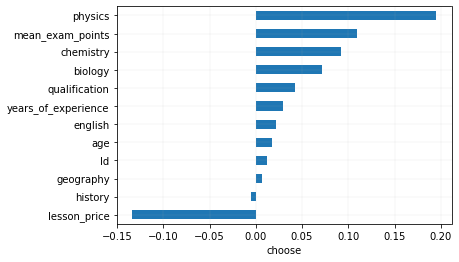

In [43]:
# Check correlation of features
data.corr().drop('choose', axis=1).loc['choose'].sort_values().plot(kind='barh')
plt.grid(linewidth=0.3, alpha=0.4)
plt.xlabel('choose')

In [44]:
features = ['age', 'years_of_experience', 'lesson_price', 'qualification', 
            'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'mean_exam_points'] 

target = 'choose'

In [45]:
# Add ones column. This one need for learn
data = pd.concat([pd.Series(np.ones(10000), name='zero'), data], axis=1)
# Scaling
data.loc[:, features] = standart_scale(data.loc[:, features])
# Add zero name in features for consistent
features.insert(0, 'zero')

In [46]:
data.head(3)

,zero,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,1.0,0,-1.345023,-1.117674,0.854466,0.345123,-0.767304,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.703552,0
1,1.0,1,0.771966,0.014262,-0.863783,0.345123,1.303134,-0.371874,2.744389,-0.250611,-0.168779,7.385804,-0.546906,1
2,1.0,2,-2.092195,0.580231,0.090800,-0.906684,1.303134,-0.371874,-0.364343,-0.250611,-0.168779,-0.135381,0.115101,0


In [47]:
train, valid = train_test_split(data, test_size=0.3, random_state=0)

Grid Search:

In [18]:
# Select parameters
iterations = np.linspace(300, 700, 3, dtype=int)
etas = np.linspace(1, 4, 15)

best_error = np.inf
best_params = {}

for iteration in iterations:
    for eta in etas:
        w, error = eval_model(train.loc[:, features], train[target], iterations=iteration, eta=eta)
        if error < best_error:
            best_error = error
            best_params = {
                'iteration': iteration,
                'eta': eta
            }
            print(f'Ошибка {best_error} при параметрах {best_params}')
        
print(f'Наименьшая ошибка {best_error} при параметрах {best_params}')

Ошибка 0.25129903446442964 при параметрах {'iteration': 300, 'eta': 1.0}
Ошибка 0.251003256144399 при параметрах {'iteration': 300, 'eta': 1.2142857142857142}
Ошибка 0.25087315876612654 при параметрах {'iteration': 300, 'eta': 1.4285714285714286}
Ошибка 0.2508141718306777 при параметрах {'iteration': 300, 'eta': 1.6428571428571428}
Ошибка 0.2507869071871422 при параметрах {'iteration': 300, 'eta': 1.8571428571428572}
Ошибка 0.25077414759437855 при параметрах {'iteration': 300, 'eta': 2.071428571428571}
Ошибка 0.25076812792915515 при параметрах {'iteration': 300, 'eta': 2.2857142857142856}
Ошибка 0.2507652732075187 при параметрах {'iteration': 300, 'eta': 2.5}
Ошибка 0.2507639149525759 при параметрах {'iteration': 300, 'eta': 2.7142857142857144}
Ошибка 0.2507632674174648 при параметрах {'iteration': 300, 'eta': 2.9285714285714284}
Ошибка 0.25076295836814166 при параметрах {'iteration': 300, 'eta': 3.142857142857143}
Ошибка 0.25076281079238205 при параметрах {'iteration': 300, 'eta': 3.3

In [48]:
# Optimal parameters: 
w, err = eval_model(train.loc[:, features], train[target], iterations=700, eta=3.7857142857142856)
w, err

(zero                  -3.129165
 age                    0.065252
 years_of_experience   -0.075426
 lesson_price          -2.902883
 qualification          1.307223
 physics                0.437780
 chemistry              0.292799
 biology                0.209619
 english                0.068264
 geography              0.027467
 history                0.022910
 mean_exam_points       1.552935
 dtype: float64,
 0.2507626759797545)

In [159]:
TPR, FPR = roc_curve(valid.loc[:, features], valid[target], w)
TPR, FPR

([0.0,
  0.005763688760806916,
  0.005763688760806916,
  0.008645533141210375,
  0.011527377521613832,
  0.011527377521613832,
  0.01440922190201729,
  0.01729106628242075,
  0.020172910662824207,
  0.023054755043227664,
  0.023054755043227664,
  0.023054755043227664,
  0.023054755043227664,
  0.025936599423631124,
  0.025936599423631124,
  0.02881844380403458,
  0.02881844380403458,
  0.03170028818443804,
  0.03170028818443804,
  0.0345821325648415,
  0.0345821325648415,
  0.0345821325648415,
  0.037463976945244955,
  0.040345821325648415,
  0.04610951008645533,
  0.04899135446685879,
  0.05187319884726225,
  0.05763688760806916,
  0.05763688760806916,
  0.05763688760806916,
  0.06628242074927954,
  0.07204610951008646,
  0.07780979827089338,
  0.08357348703170028,
  0.08645533141210375,
  0.08645533141210375,
  0.09221902017291066,
  0.09510086455331412,
  0.1037463976945245,
  0.10951008645533142,
  0.12103746397694524,
  0.12968299711815562,
  0.13544668587896252,
  0.1354466858789

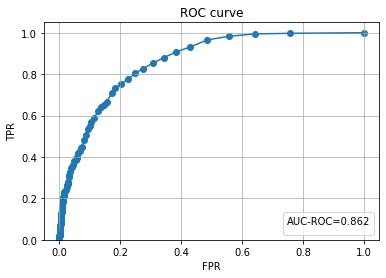

In [160]:
AUC_ROC = np.trapz(TPR, x=FPR)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR);
plt.scatter(FPR, TPR);

### Predict Test.csv

In [52]:
test = pd.concat([pd.Series(np.ones(10000), name='zero'), test], axis=1)
test.loc[:, features[1:]] = standart_scale(test.loc[:, features[1:]])
test.head(3)

,zero,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,1.0,10000,-1.733633,0.008074,1.900372,1.643400,-0.769773,-0.383283,-0.361874,-0.226979,-0.173422,-0.123814,1.904968
1,1.0,10001,-1.360126,2.266408,0.190191,0.377006,1.298954,2.608778,-0.361874,-0.226979,-0.173422,-0.123814,0.504831
2,1.0,10002,-0.239605,0.008074,-0.949930,-0.889389,-0.769773,-0.383283,-0.361874,-0.226979,-0.173422,-0.123814,-1.411147


In [54]:
# pred_test = predict(test.loc[:, features], w)
# pred_test

array([0, 0, 0, ..., 0, 1, 0])

In [55]:
# "predicted" should be in probabilities for best score ROC AUC at Kaggle 
pred_test = sigmoid(np.dot(test.loc[:, features], w))
pred_test

array([0.0147589 , 0.19300348, 0.01351846, ..., 0.32644976, 0.89404343,
       0.02005859])

In [118]:
samples['choose'] = pred_test
samples.head(3)

,Id,choose
0,10000,0.014759
1,10001,0.193003
2,10002,0.013518


In [57]:
samples.to_csv('submissions.csv', index=None)

In [58]:
pd.read_csv('submissions.csv').head(3)

,Id,choose
0,10000,0.014759
1,10001,0.193003
2,10002,0.013518


### Conclusion:

I've got top-3 result in the internal Geekbrains competition:

### Check probabilities (can be deleted)

In [139]:
samples2 = samples.copy()
samples2.head(3)

,Id,choose
0,10000,0.014759
1,10001,0.193003
2,10002,0.013518


In [140]:
samples2['choose'] += np.random.uniform(-1e-2, 1e-2)
samples2['choose']

0       0.008169
1       0.186414
2       0.006929
3       0.005147
4       0.185603
          ...   
9995    0.129417
9996    0.005825
9997    0.319860
9998    0.887454
9999    0.013469
Name: choose, Length: 10000, dtype: float64

In [141]:
TPR, FPR = roc_curve(test.loc[:, features], samples2['choose'], w)
TPR, FPR

([0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.0,
  0.00030003000300030005,
  0.0,
  0.00010004001600640257,
  0.00010005002501250626,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00010013016921998598,
  0.0,
  0.00040064102564102563,
  0.0002004208838560978,
  0.0002005012531328321,
  0.0003008725303379801,
  0.0002006823198876179,
  0.0002007226013649

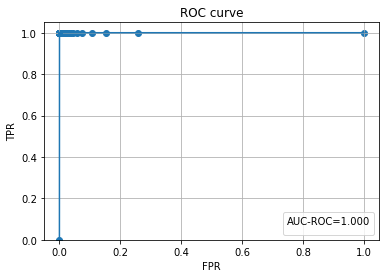

In [142]:
AUC_ROC = np.trapz(TPR, x=FPR)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR);
plt.scatter(FPR, TPR);

In [153]:
AUC_ROC

0.8615470931173562

Compare with sklearn metric

In [143]:
from sklearn.metrics import roc_auc_score

In [163]:
roc_auc_score(valid[target], sigmoid(np.dot(valid.loc[:, features], w)))

0.8613015986469562

In [162]:
roc_auc_score(valid[target], predict(valid.loc[:, features], w))

0.5962745670987442

In [155]:
samples2['choose']

0       0.008169
1       0.186414
2       0.006929
3       0.005147
4       0.185603
          ...   
9995    0.129417
9996    0.005825
9997    0.319860
9998    0.887454
9999    0.013469
Name: choose, Length: 10000, dtype: float64

In [157]:
roc_auc_score(predict(test.loc[:, features], w), sigmoid(np.dot(test.loc[:, features], w)))

1.0